In [3]:
import pandas as pd
import numpy as np
from scipy.stats import kstest
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
#import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as MSE

In [4]:
# read in data with resume score
df = pd.read_csv('data/random_df_final.csv')
df.head()

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,...,Start 1,End 1,Role 2,Start 2,End 2,Role 3,Start 3,End 3,Resume score,Candidate evaluation
0,1,University of Alabama,3.35,PhD,Los Angeles,F,NaN,0,0.0,4,...,06/06,08/08,Lawyer,08/08,03/09,Junior SWE,04/09,08/10,7.09,0
1,2,Stanford University,3.90,Masters,New York City,NaN,NaN,1,NaN,2,...,01/07,03/09,NaN,NaN,NaN,NaN,NaN,NaN,9.02,0
2,3,Cornell University,2.28,PhD,Dallas,F,0.0,0,1.0,1,...,12/08,02/11,Research Assistant,02/11,09/11,ML Engineer,11/11,06/14,8.09,1
3,4,University of Washington,3.21,Bachelors,San Diego,M,1.0,1,1.0,3,...,09/05,02/06,Lawyer,05/06,02/08,Research Assistant,03/08,07/10,9.18,0
4,5,University of Kansas,3.56,Bachelors,Chicago,F,0.0,1,0.0,1,...,10/02,04/03,Research Assistant,04/03,10/04,Teaching Assistant,11/04,08/06,5.27,0


In [5]:
df.describe()

,Applicant ID,GPA,Veteran status,Work authorization,Disability,Ethnicity,Resume score,Candidate evaluation
count,1500.000000,1500.000000,977.000000,1500.000000,1014.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,3.002880,0.506653,0.513333,0.500986,2.033333,5.076220,0.296667
std,433.157015,0.579316,0.500212,0.499989,0.500246,1.438147,2.939157,0.456941
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000
25%,375.750000,2.510000,0.000000,0.000000,0.000000,1.000000,2.470000,0.000000
50%,750.500000,3.010000,1.000000,1.000000,1.000000,2.000000,5.160000,0.000000
75%,1125.250000,3.500000,1.000000,1.000000,1.000000,3.000000,7.690000,1.000000
max,1500.000000,3.990000,1.000000,1.000000,1.000000,4.000000,10.000000,1.000000


In [6]:
df = df.replace(np.nan, 'N/A')
cat_cols = ['School Name', 'GPA', 'Degree', 'Location', 'Gender',
       'Veteran status', 'Work authorization', 'Disability', 'Ethnicity', 'Role 1', 'Role 2', 'Role 3']
for col in cat_cols:
    print(df[col].value_counts())

School Name
University of Massachusetts Amherst            33
University of Alabama                          32
University of Miami                            32
Indiana University Bloomington                 31
University of Washington                       30
                                               ..
Florida State University                       16
University of Michigan                         16
Massachusetts Institute of Technology (MIT)    15
Carnegie Mellon University                     15
Virginia Tech                                  13
Name: count, Length: 67, dtype: int64
GPA
3.10    15
3.69    15
2.27    15
2.98    14
3.44    14
        ..
3.78     2
2.85     2
3.04     2
2.07     1
2.72     1
Name: count, Length: 200, dtype: int64
Degree
Bachelors    512
Masters      504
PhD          484
Name: count, dtype: int64
Location
Phoenix          164
San Antonio      160
Los Angeles      159
San Diego        158
Houston          155
Philadelphia     153
New York City    

In [7]:
# sensitive attributes:
attributes = ['Gender',
              'Work authorization',
              'Disability',
              'Ethnicity']

for attr in attributes:
    print(df[attr].value_counts())

Gender
F      501
N/A    500
M      499
Name: count, dtype: int64
Work authorization
1    770
0    730
Name: count, dtype: int64
Disability
1.0    508
0.0    506
N/A    486
Name: count, dtype: int64
Ethnicity
4    324
0    307
3    297
2    291
1    281
Name: count, dtype: int64


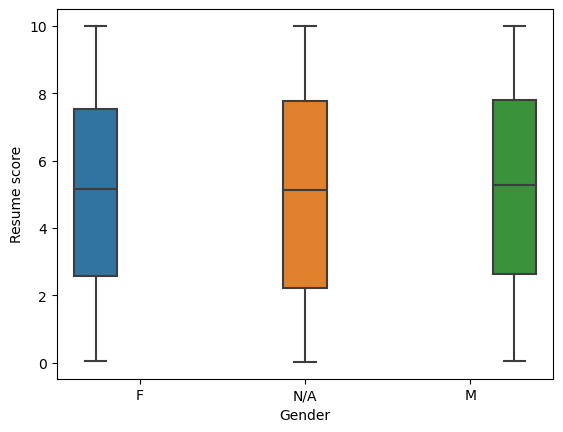

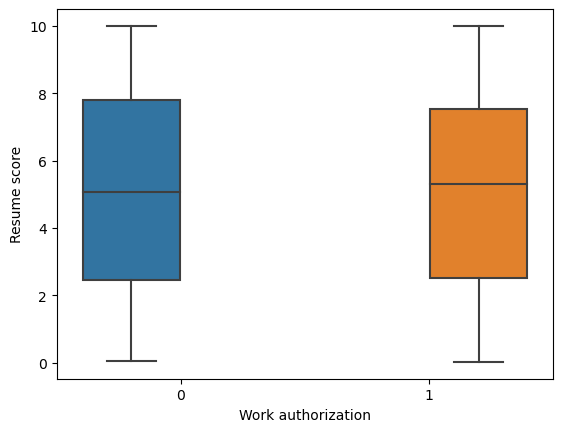

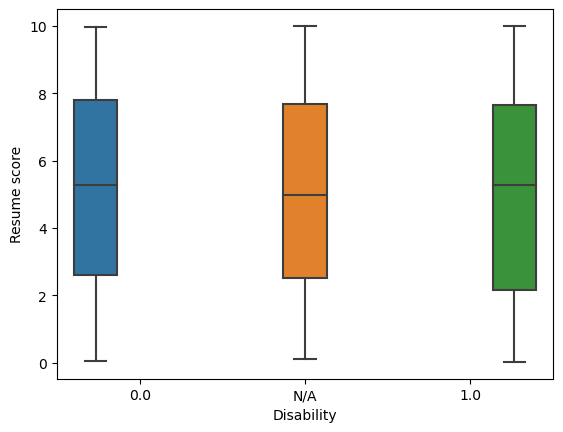

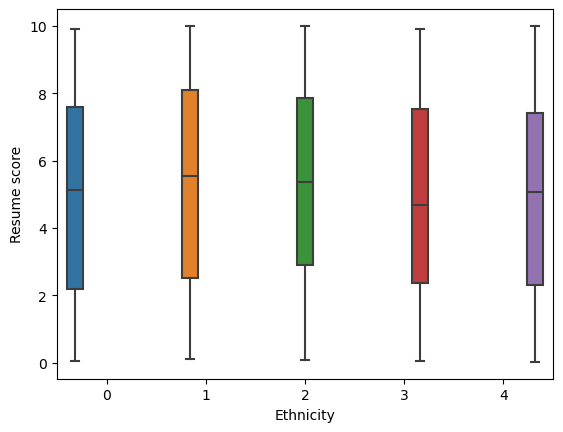

In [9]:
# calculate and plot distribution of each sensitive group:
attributes = ['Gender',
              'Work authorization',
              'Disability',
              'Ethnicity']

summary = pd.DataFrame(columns = ['Group','mean','std','min','max'])
box_plots = []

for attr in attributes:
    # calculate summary statistics:
    agg = (df.groupby(attr)['Resume score']
                .agg(['mean','std','min','max']))
    agg = agg.reset_index()
    agg[attr] = agg[attr].map(lambda x: f"{attr}_{x}")
    agg = agg.rename(columns = {attr:'Group'})

    summary = pd.concat([summary, agg])

    # make box_plots:
    box = sns.boxplot(x = attr,
            y = 'Resume score',
            data = df,
            hue = attr)
    plt.legend('', frameon=False)
    plt.savefig(f'figs/{attr}.jpg')
    plt.show()

In [ ]:
summary.to_csv('resume_analysis_summary.csv')

In [54]:
# compute KS-statistic for each attribute
# to determine if the distributions are actually statistically significantly different from each other
KS_summary = pd.DataFrame(columns=['Group 1','Group 2','statistic', 'pvalue'])

for attr in attributes:
    unique = df[attr].unique()
    for i in range(len(unique)):
        for j in range(i+1, len(unique)):
            ks_test = kstest(df[df[attr] == unique[i]]['Resume score'], df[df[attr] == unique[j]]['Resume score'])
            KS_summary.loc[len(KS_summary)] = [f'{attr} {i}',f'{attr} {j}'] + list(ks_test)

In [56]:
KS_summary.to_csv('ks_summary.csv')

In [ ]:
# Model interpretability: randomly perturb each column, feed it through the model, and see how the results change
# use the original result as baseline comparison, calculate MSE between new result and old result

'''
Note: here we used a different dataset than the dataset used in the rest of the analysis, 
after completing the permutation analysis, we needed to switch to a different dataset for other parts of the analysis because this dataset ran into formatting issues with the Candidate Scorer system
'''
df_train = pd.read_csv('random_df_2k.csv')

permutation_attributes = ['School Name', 'GPA', 'Degree', 'Location', 'Gender',
       'Veteran status', 'Work authorization', 'Disability', 'Ethnicity']

# create perturbed datasets
for attr in permutation_attributes:
    df_temp = df_train.copy()
    df_temp[attr] = np.random.permutation(df_train[attr].values)
    df_temp.to_csv(f'permutated_data/random_df_2k_{attr}.csv', index=False)


In [ ]:
# calculate MSE between perturbed results and original results:
permutation_MSE = pd.DataFrame(columns = ['Attribute', 'MSE'])

for attr in permutation_attributes:
    attr_result = pd.read_csv(f'permutated_data/result_2k_{attr}.csv')
    mse = MSE(attr_result['score'], df['Resume score'])
    permutation_MSE.loc[len(permutation_MSE.index)] = [attr, mse]

In [ ]:
permutation_MSE['Sensitive'] = permutation_MSE['Attribute'].isin(attributes)
permutation_MSE = permutation_MSE.sort_values(by = 'MSE')

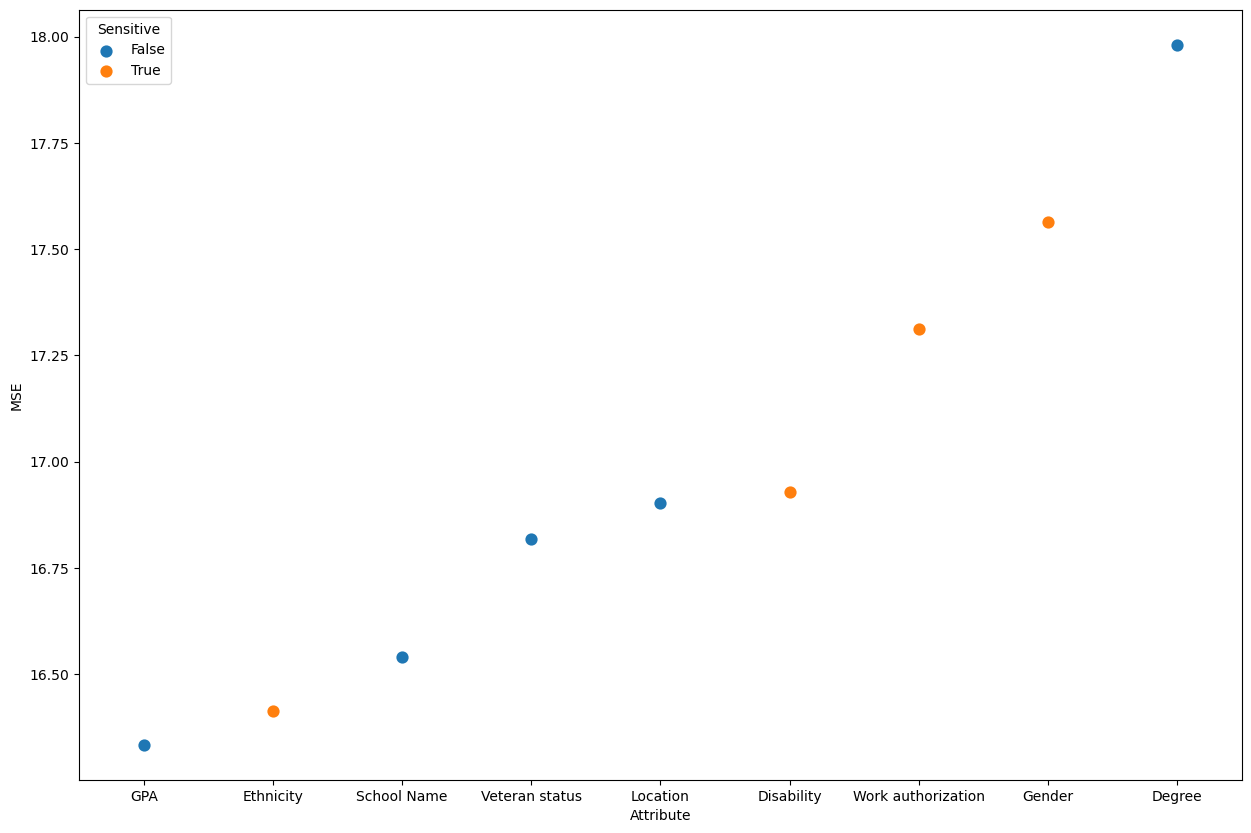

In [ ]:
# plot MSE for each attribute:
plt.figure(figsize = (15,10))
sns.pointplot(data=permutation_MSE,
              x = 'Attribute',
              y = 'MSE',
              linestyles = "None",
              hue = 'Sensitive')
plt.savefig('resume_score_permutation.jpg')
plt.show()

## Other Code / experiments:

In [ ]:
# model interpretability: SHAP
# currently doesnt work :(
df_X = df.drop(columns = ['Resume score','Resume Score Binary'])
cat_cols = ['School Name', 'Degree', 'Location', 'Gender',
       'Veteran status', 'Work authorization', 'Disability', 'Ethnicity',
       'Role 1', 'Start 1', 'End 1', 'Role 2', 'Start 2', 'End 2', 'Role 3',
       'Start 3', 'End 3']
other_cols = [col for col in df_X.columns if col not in cat_cols]
encoder = OneHotEncoder()
X_cat = df_X[cat_cols].astype(str)
X_encoded = encoder.fit_transform(X_cat).toarray()
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols))

df_X_encoded = pd.concat([df_X[other_cols],X_encoded_df], axis=1)

df_y = df['Resume score']

# SHAP
def f(row):
    '''
    Function to output predicted value given training values
    '''
    print(row.shape)
    print(df_X_encoded.index[(df_X_encoded.values == row).all(axis=1)])
    ind = df_X_encoded.index[(df_X_encoded.values == row).all(axis=1)][0]
    return df_y.iloc[ind]

med = df_X_encoded.median().values.reshape((1, df_X_encoded.shape[1]))

In [69]:
interaction_summary = pd.DataFrame()
# feature interactions:
attributes = ['Gender',
              'Work authorization',
              'Disability',
              'Ethnicity']

summary = pd.DataFrame(columns = ['Group','mean','std','min','max'])
box_plots = []
# metrics = pd.DataFrame(columns = ['Group','Independence','SPD','DI'])

for i in range(len(attributes)):
    for j in range(i+1,len(attributes)):
        attr1 = attributes[i]
        attr2 = attributes[j]
    # calculate summary statistics:
        agg = (df.groupby([attr1, attr2])['Resume score']
                    .agg(['mean','std','min','max']))

        agg = agg.reset_index()
        agg['group'] = attr1 + '_' + agg[attr1].astype(str) + '_' + attr2 + '_' + agg[attr2].astype(str)
        print(agg)
        # agg[attr] = agg[attr].map(lambda x: f"{attr1}_{attr2}_{x}")
        # agg = agg.rename(columns = {attr:'Group'})

        interaction_summary = pd.concat([interaction_summary, agg])

        # make box_plots:
        box = sns.boxplot(x = 'group',
                y = 'Resume score',
                data = agg,
                hue = 'group',
                error)
        plt.legend('', frameon=False)
        #plt.savefig(f'/content/drive/MyDrive/CSCI1951/CS1951 Final Project/{attr}.jpg')
        plt.show()


  Gender  Work authorization      mean       std   min    max  \
0      F                   0  5.051667  2.907818  0.04   9.90   
1      F                   1  5.080196  2.833022  0.04   9.99   
2      M                   0  5.251411  2.960378  0.09  10.00   
3      M                   1  5.028367  2.926607  0.06   9.90   
4    N/A                   0  4.939153  3.067500  0.04   9.99   
5    N/A                   1  5.098712  2.963061  0.02   9.80   

                             group  
0    Gender_F_Work authorization_0  
1    Gender_F_Work authorization_1  
2    Gender_M_Work authorization_0  
3    Gender_M_Work authorization_1  
4  Gender_N/A_Work authorization_0  
5  Gender_N/A_Work authorization_1  


ValueError: Could not interpret value `group` for `x`. An entry with this name does not appear in `data`.